In [ ]:
!pip3 install virtualenv
!virtualenv ai_course_env

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 13.1 MB/s eta 0:00:00
created virtual environment CPython3.10.12.final.0-64 in 2144ms
  creator CPython3Posix(dest=/content/ai_course_env, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==24.2, setuptools==74.1.2, wheel==0.44.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [ ]:
!source /content/ai_course_env/bin/activate; pip install gensim==3.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached numpy-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached smart_open-7.0.4-py3-none-any.whl.metadata (23 kB)
  Using cached wrapt-1.16.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
Using cached numpy-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 23.3 MB/s eta 0:00:00
Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
Using cached smart_open-7.0.4-py3-none-any.whl (61 kB)
Using cached wrapt-1.16.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (80 kB)
  Created wheel for gensim: filename=gensim-3.8.0-cp310-cp310-linux_x86_64.whl size=237

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# mount Google Drive to Colab session
from google.colab import drive
drive.mount('/content/drive')

# copy to session drive ('/content')
!cp -r /content/drive/MyDrive/IMDB_Dataset.xlsx /content

import os
dataset_path = os.path.abspath(os.getcwd()) + "/" + "IMDB_Dataset.xlsx"

Mounted at /content/drive


In [ ]:
df = pd.read_excel(dataset_path, sheet_name = 'Sheet1').drop(['Unnamed: 0'], axis = 1)
df

,Movie,ImgLink,Description
0,Project Power,https://m.media-amazon.com/images/M/MV5BYzBhOW...,When a pill that gives its users unpredictable...
1,The Tax Collector,https://m.media-amazon.com/images/M/MV5BMmFmZT...,"A ""tax collector"" working for a local crime lo..."
2,Perry Mason,https://m.media-amazon.com/images/M/MV5BMDllMW...,"In booming 1932 Los Angeles, a down-and-out de..."
3,Yellowstone,https://m.media-amazon.com/images/M/MV5BZjhkNW...,A ranching family in Montana faces off against...
4,Dark,https://m.media-amazon.com/images/M/MV5BZmY2Yz...,"A family saga with a supernatural twist, set i..."
...,...,...,...
9995,Paprika,https://m.media-amazon.com/images/M/MV5BZWMxYz...,A young country girl comes to town and works i...
9996,I'm Alan Partridge,https://m.media-amazon.com/images/M/MV5BODRmYz...,"Alan Partridge, a failed television presenter,..."
9997,Deep in the Valley,https://m.media-amazon.com/images/M/MV5BZmY4M2...,A mysterious video booth transports two friend...
9998,The Red Turtle,https://m.media-amazon.com/images/M/MV5BNGZlYz...,A man is shipwrecked on a deserted island and ...


In [ ]:
# Function for removing ASCII characters
def _removeNonAscii(s):
    return "".join(i for i in s if ord(i)<128)

# Function for converting to lower case
def make_lower_case(text):
    return text.lower()

# Function for removing stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# Function for removing html
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

df['Cleaned'] = df['Description'].apply(_removeNonAscii)
df['Cleaned'] = df.Cleaned.apply(func = make_lower_case)
df['Cleaned'] = df.Cleaned.apply(func = remove_stop_words)
df['Cleaned'] = df.Cleaned.apply(func = remove_punctuation)
df['Cleaned'] = df.Cleaned.apply(func = remove_html)

In [ ]:
df

,Movie,ImgLink,Description,Cleaned
0,Project Power,https://m.media-amazon.com/images/M/MV5BYzBhOW...,When a pill that gives its users unpredictable...,pill gives users unpredictable superpowers fiv...
1,The Tax Collector,https://m.media-amazon.com/images/M/MV5BMmFmZT...,"A ""tax collector"" working for a local crime lo...",tax collector working local crime lord finds f...
2,Perry Mason,https://m.media-amazon.com/images/M/MV5BMDllMW...,"In booming 1932 Los Angeles, a down-and-out de...",booming 1932 los angeles down and out defense ...
3,Yellowstone,https://m.media-amazon.com/images/M/MV5BZjhkNW...,A ranching family in Montana faces off against...,ranching family montana faces others encroachi...
4,Dark,https://m.media-amazon.com/images/M/MV5BZmY2Yz...,"A family saga with a supernatural twist, set i...",family saga supernatural twist set german town...
...,...,...,...,...
9995,Paprika,https://m.media-amazon.com/images/M/MV5BZWMxYz...,A young country girl comes to town and works i...,young country girl comes town works brothel or...
9996,I'm Alan Partridge,https://m.media-amazon.com/images/M/MV5BODRmYz...,"Alan Partridge, a failed television presenter,...",alan partridge failed television presenter pre...
9997,Deep in the Valley,https://m.media-amazon.com/images/M/MV5BZmY4M2...,A mysterious video booth transports two friend...,mysterious video booth transports two friends ...
9998,The Red Turtle,https://m.media-amazon.com/images/M/MV5BNGZlYz...,A man is shipwrecked on a deserted island and ...,man shipwrecked deserted island encounters red...


In [ ]:
# Splitting the description into words

corpus = []
for words in df['Cleaned']:
    corpus.append(words.split())

In [ ]:
corpus

[['pill',
  'gives',
  'users',
  'unpredictable',
  'superpowers',
  'five',
  'minutes',
  'hits',
  'streets',
  'new',
  'orleans',
  'teenage',
  'dealer',
  'local',
  'cop',
  'must',
  'team',
  'ex',
  'soldier',
  'take',
  'group',
  'responsible',
  'creation'],
 ['tax',
  'collector',
  'working',
  'local',
  'crime',
  'lord',
  'finds',
  'family',
  's',
  'safety',
  'compromised',
  'rival',
  'boss',
  'shows',
  'l',
  'a',
  'upends',
  'business'],
 ['booming',
  '1932',
  'los',
  'angeles',
  'down',
  'and',
  'out',
  'defense',
  'attorney',
  'takes',
  'case',
  'lifetime'],
 ['ranching', 'family', 'montana', 'faces', 'others', 'encroaching', 'land'],
 ['family',
  'saga',
  'supernatural',
  'twist',
  'set',
  'german',
  'town',
  'disappearance',
  'two',
  'young',
  'children',
  'exposes',
  'relationships',
  'among',
  'four',
  'families'],
 ['quinn',
  'ackerman',
  's',
  'admission',
  'college',
  'dreams',
  'depends',
  'performance',
  'da

In [ ]:
# mount Google Drive to Colab session
from google.colab import drive
drive.mount('/content/drive')

# copy to session drive ('/content')
!cp -r /content/drive/MyDrive/GoogleNews-vectors-negative300.bin /content

# load word2vec model
import os
gn_vec_path = os.path.abspath(os.getcwd()) + "/" + "GoogleNews-vectors-negative300.bin"

from gensim.models import Word2Vec, KeyedVectors
google_word2vec = KeyedVectors.load_word2vec_format(gn_vec_path, binary=True) #load the model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Training our corpus with the model
google_model = Word2Vec(vector_size = 300, window = 5, min_count = 2, workers = -1)
google_model.build_vocab(corpus)
google_model.wv.vectors_lockf = np.ones(len(google_model.wv))

google_model.wv.intersect_word2vec_format(gn_vec_path, lockf = 1.0, binary = True)
google_model.train(corpus, total_examples = google_model.corpus_count, epochs = 5)

(0, 0)

In [ ]:
def vectors(x):

    # Creating a list for storing the vectors ('Description' into vectors)
    global word_embeddings
    word_embeddings = []

    # Reading the each 'Description'
    for line in df['Cleaned']:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in google_model.wv.key_to_index:
                count += 1
                if avgword2vec is None:
                    avgword2vec = google_model.wv[word]
                else:
                    avgword2vec = avgword2vec + google_model.wv[word]

        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
            word_embeddings.append(avgword2vec)

In [ ]:
# Recommending the Top 5 similar movies
def recommendations(movie):
    # Calling the function vectors
    vectors(df)
    # Finding cosine similarity for the vectors
    cosine_similarities = cosine_similarity(word_embeddings, word_embeddings)
    # Taking the Title and Movie Image Link and store in new dataframe called 'movies'
    movies = df[['Movie', 'ImgLink']]

    # Reverse mapping of the index
    indices = pd.Series(df.index, index = df['Movie']).drop_duplicates()

    idx = indices[movie]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    recommend = movies.iloc[movie_indices]

    for index, row in recommend.iterrows():
        response = requests.get(row['ImgLink'])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        plt.title(row['Movie'])

Let's get recommendations based on the movie 'Dil Bechara'.

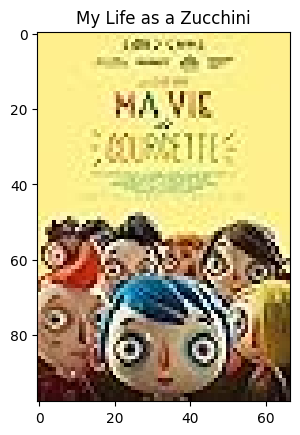

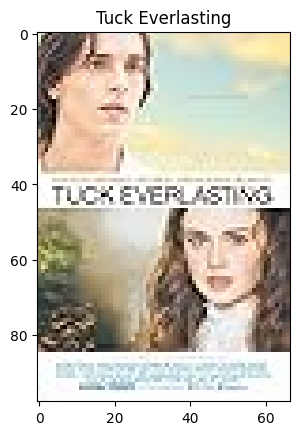

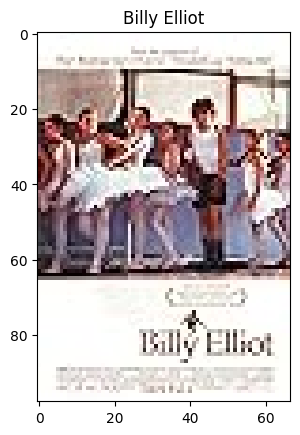

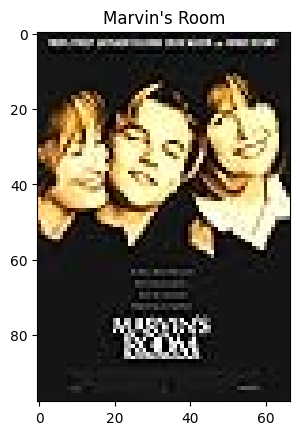

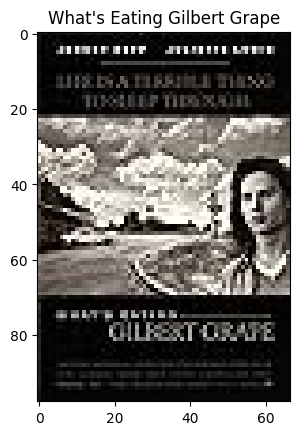

In [ ]:
recommendations('Dil Bechara')

*This movie belongs to "**Romance/Drama**" genre and it recommends similar kinds of movies.*

Now, let's get a recommendation on the movie 'Avengers: Endgame'.

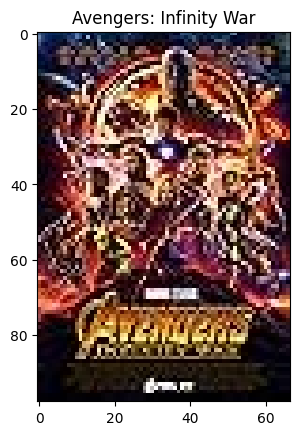

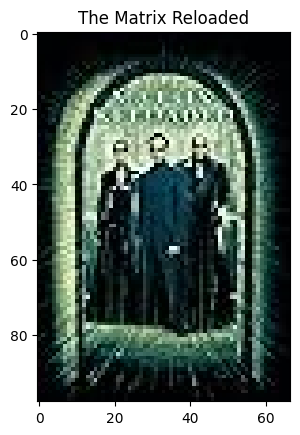

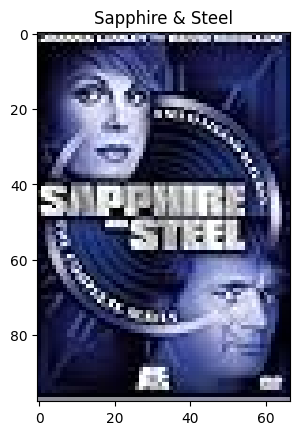

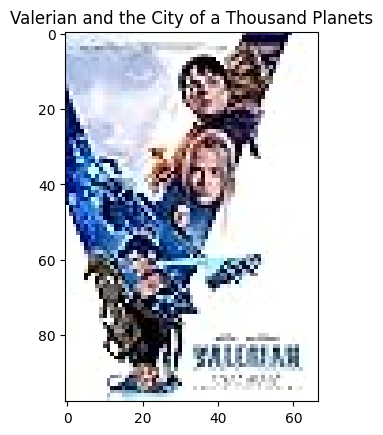

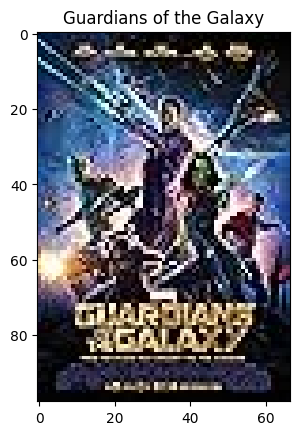

In [ ]:
recommendations('Avengers: Endgame')

In [ ]:
# Building the TF-IDF model and calculating the TF-IDF score
tfidf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 3), min_df = 5, stop_words = 'english')
# tfidf_vectors = tfidf.fit(df['Cleaned'])
# tfidf_vectors = tfidf.transform(df['Cleaned'])
tfidf_vectors = tfidf.fit_transform(df['Cleaned'])

# Getting the words from the TF-IDF model
tfidf_list = dict(zip(tfidf.get_feature_names_out(), list(tfidf.idf_)))

# TF-IDF words/column names
tfidf_feature = tfidf.get_feature_names_out()

In [ ]:
# Building TF-IDF Word2vec Embeddings

# Storing the TFIDF Word2Vec embeddings
tfidf_vectors = []
line = 0

# For each 'Description'
for desc in corpus:

    # Word vectors are of zero length (using 300 dimensions)
    sent_vec = np.zeros(300)

    # Number of words with a valid vector in the 'Description'
    weight_sum =0;

    # For each word in the 'Description'
    for word in desc:
        if word in google_model.wv.key_to_index and word in tfidf_feature:
            vec = google_model.wv[word]
            tf_idf = tfidf_list[word] * (desc.count(word) / len(desc))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors.append(sent_vec)
    line += 1


### Top 5 Recommendation using TF-IDF Word2vec

In [ ]:
# Recommending top 5 similar movies
def recommendations_2(movie):

    # Finding cosine similarity for the vectors
    cosine_similarities = cosine_similarity(tfidf_vectors,  tfidf_vectors)

    # Taking the Title and Image Link and store in new data frame called movies
    movies = df[['Movie', 'ImgLink']]

    # Reverse mapping of the index
    indices = pd.Series(df.index, index = df['Movie']).drop_duplicates()

    idx = indices[movie]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    recommend = movies.iloc[movie_indices]
    for index, row in recommend.iterrows():

        response = requests.get(row['ImgLink'])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        plt.title(row['Movie'])

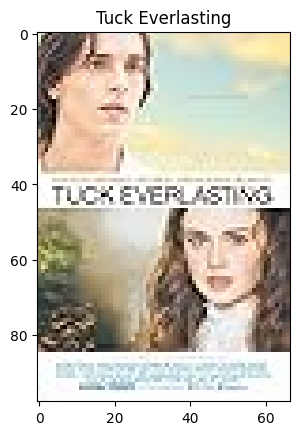

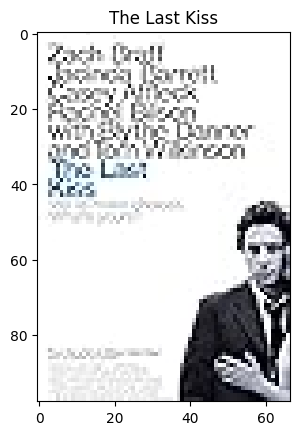

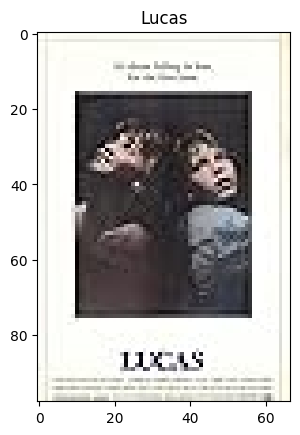

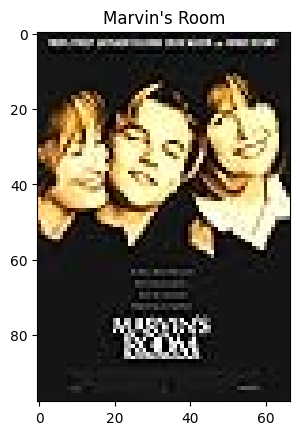

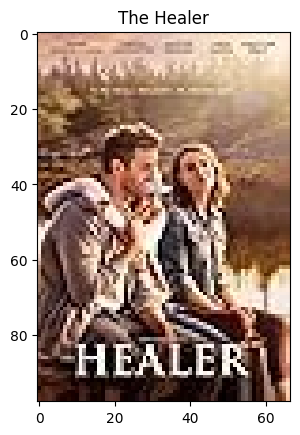

In [ ]:
recommendations_2('Dil Bechara')

*The recommendations this time are a bit different & only two movies are common recommendations in both the outputs. But, the newly recommended movies also belong to a similar genre.*

Now, let's try to generate recommendations for a horror movie 'The Conjuring'.

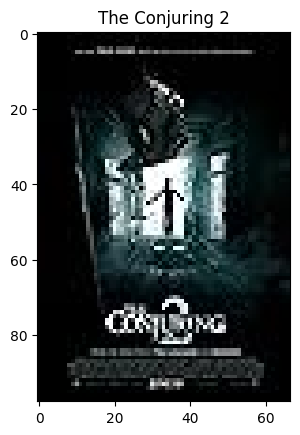

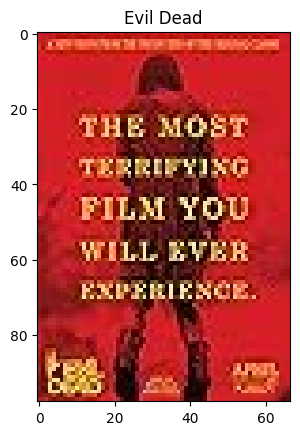

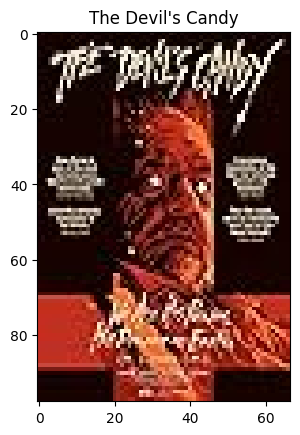

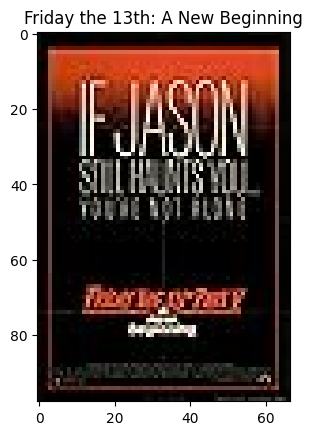

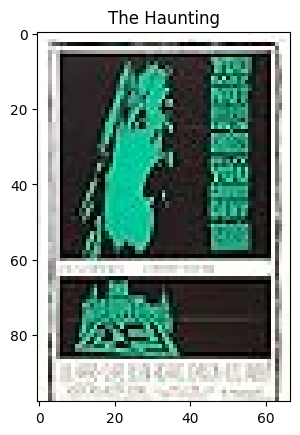

In [ ]:
recommendations_2('The Conjuring')

*We can clearly see that our recommendation engine recommends other Horror movies based on the movie 'The Conjuring'.*